# Receives partial offer containing only price

`validate_partial_offer()` calls `is_price_feasible()`:

Buyer case

- Given a **price \(X\)**, assume the **maximum quantity \(Q = 100\)** (or maximum demand).

- Compute the buyer’s **maximum profit at price \(X\)** with \(Q = 100\).

- If this maximum profit is **greater than or equal to the Nash profit**:
  - Call `optimal_quality_for_wholesale_price()`

- Otherwise, if the maximum profit **is less than the Nash profit** <span style="color:#e53935">(the term is too unfavourable)</span>:
  - Send the **Nash equilibrium offer** directly.

Supplier Case

- Given a **price \(X\)**, compute the **optimal quantity** for the supplier using the formula:
  
  $$
  Q = d_{max} - \frac{production\_cost \times (d_{max} - d_{min})}{X}
  $$

- Compute the **supplier’s maximum profit at price \(X\)** using this quantity \(Q\).

- If this maximum profit is **greater than or equal to the Nash profit**:
  - Call `optimal_quality_for_wholesale_price()`

- Otherwise, if the maximum profit **is less than the Nash profit** <span style="color:#e53935">(the term is too unfavourable)</span>:
  - Send the **Nash equilibrium offer** directly.

# Receives partial offer containing only quantity

`validate_partial_offer()` calls `is_quality_feasible()`:

Buyer case

- Given a **quantity \(X\)**

- Compute the buyer’s **minimum acceptable price** with \(Q = X\) **to reach nash_profit**.

- If the minimum acceptable price is **less than 0** or **greater than the Retail Price** <span style="color:#e53935">(the term is too unfavourable)</span>:
  - Send the **Nash equilibrium offer** directly.

- Otherwise, if it is between acceptable margins:
  - Call `optimal_wholesale_price_for_quality()`

Supplier Case

- Given a **quantity \(X\)**

- Compute the supplier's **maximum acceptable price** with \(Q = X\) **to reach nash_profit**.

- If the maximum acceptable price is **less than the PC** <span style="color:#e53935">(the term is too unfavourable)</span>:
  - Send the **Nash equilibrium offer** directly.

- Otherwise, if it is between acceptable margins:
  - Call `optimal_wholesale_price_for_quality()`

# Partial offer contains easy Quantity

Adjust the price with `optimal_wholesale_price_for_quality()`
using inverse formula of profit with fixed quantity (given)

# Partial offer contains easy wholesale price

Adjust the quantity with `optimal_quality_for_wholesale_price()` using inverse formula of profit with fixed price (given).  
This involves solving a quadratic equation derived
from the profits' equations:

$$
\text{target\_profit\_buyer} = (market\_price - wholesale\_price) \times ES(q)
$$ 

$$
\text{target\_profit\_supplier} = (wholesale\_price \times ES(q)) - production\_cost \times q
$$

where 

$$
ES(q) = \frac{(quality^2 - demand\_min^2)}{2} + quality \times \frac{(demand\_max - quality)}{(demand\_max - demand\_min)}
$$

The roots represent points where the profit exactly matches the target.

Next, the vertex (peak) of the profit function is identified—the quality value that maximizes the continuous profit function.  
For the buyer, this is typically at the maximum demand; for the supplier, it’s at a point adjusted by production cost and price.

To select practical integer quality values, the code samples integers around the roots, the vertex, and the demand boundaries,  
ensuring all promising candidates are considered.

Finally, **among candidates that satisfy the bot’s profit being at least the Nash target, the function selects the quantity that**  
**maximizes the user’s profit**, aiming for negotiation efficiency. In case of ties, it chooses the quality maximizing the combined
total profit.  
If none satisfy the target, it returns no feasible solution.



# Testing it

In [3]:
def expected_demand(quality: int, demand_min: int, demand_max: int) -> float:
    if quality <= demand_min:
        return quality
    if quality >= demand_max:
        return (demand_min + demand_max) / 2
    return ((quality ** 2 - demand_min * demand_min) / 2 + quality * (demand_max - quality)) / (demand_max - demand_min)


def profit_supplier(price: int, quality: int, production_cost: int, demand_min: int, demand_max: int) -> float:
    expected_sales = expected_demand(quality, demand_min, demand_max)
    return (price * expected_sales) - (production_cost * quality)


def profit_buyer(price: int, quality: int, market_price: int, demand_min: int, demand_max: int) -> float:
    expected_sales = expected_demand(quality, demand_min, demand_max)
    return (market_price - price) * expected_sales


In [26]:
w=7 #try 7.30 or 8
p=10
c=3
q=100-(3*100/(w))
q # INFLEXION Q 

57.142857142857146

In [23]:
profit_buyer(7.31,70,p,0,100)


122.39500000000002

In [24]:
optimal_w= 7.31
optimal_q= 70
profit_supplier(optimal_w,optimal_q,c,0,100)

122.60499999999996

Inflection point of q: 62.5
Expected profits: 156.25
Nash eq profits: 122.60499999999996


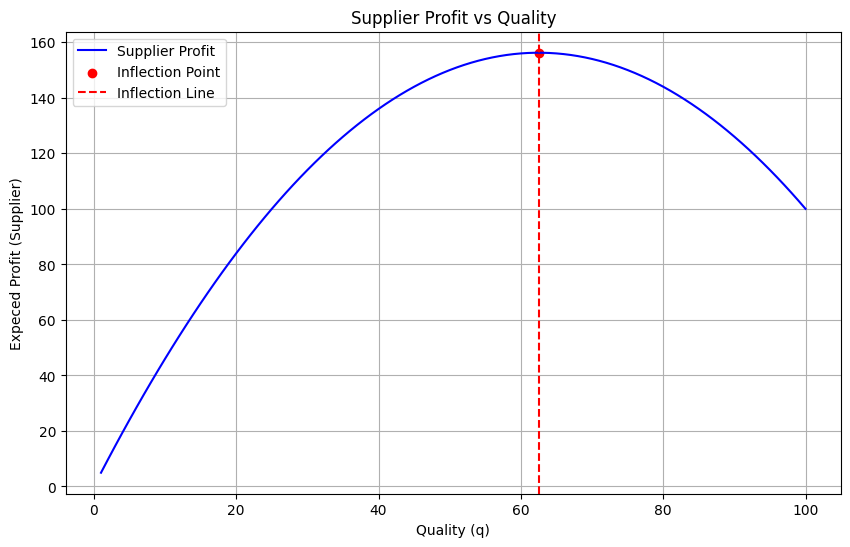

In [25]:
import matplotlib.pyplot as plt

inflection_q = 100 - (c * 100 / w)
print(f"Inflection point of q: {inflection_q}")
q_values = range(1, 101)
profit_values = [profit_supplier(w, q, c, 0, 100) for q in q_values]
print(f"Expected profits: {profit_supplier(w, inflection_q, c, 0, 100)}")
print(f"Nash eq profits: {profit_supplier(optimal_w,optimal_q,c,0,100)}")
# Plot the profit_supplier against q
plt.figure(figsize=(10, 6))
plt.plot(q_values, profit_values, label="Supplier Profit", color="blue")

# Highlight the inflection point
plt.scatter([inflection_q], [profit_supplier(w, inflection_q, c, 0, 100)], color="red", label="Inflection Point")
plt.axvline(x=inflection_q, color="red", linestyle="--", label="Inflection Line")

plt.xlabel("Quality (q)")
plt.ylabel("Expeced Profit (Supplier)")
plt.title("Supplier Profit vs Quality")
plt.legend()
plt.grid()
plt.show()